# Plots for mutation-transmissibility paper

This notebook generates plots for the [paper/](paper/) directory. This assumes you've alread run
```sh
make update        # ~10 minutes on CPU (mostly sequence alignment)
python mutrans.py  # ~2 hours on GPU
```

In [27]:
import datetime
import math
import os
import pickle
import logging
from collections import Counter, OrderedDict, defaultdict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pyro.distributions as dist
from pyrocov import mutrans, pangolin, stats
from pyrocov.stats import normal_log10bf

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)
matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams["axes.edgecolor"] = "gray"
# matplotlib.rcParams["axes.linewidth"] = 0.5
matplotlib.rcParams["lines.markeredgewidth"]
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial', 'Avenir', 'DejaVu Sans']

In [28]:
def correlation(x, y):
    x = (x - x.mean()) / x.std()
    y = (y - x.mean()) / y.std()
    return (x * y).mean()

## Load data

In [32]:
%%time
def load_data():
    filename = "results/mutrans.data.single.pt"
    if os.path.exists(filename):
        dataset = torch.load(filename)
    else:
        dataset = mutrans.load_gisaid_data()
        torch.save(datset, filename)
    dataset.update(mutrans.load_jhu_data(dataset))
    return dataset
dataset = load_data()
print(dataset.keys())
locals().update(dataset)
print(len(mutations))

   273736 Loaded 481 x 3617 daily case data, totaling 196010784.0
   273737 Joining GISAID and JHU region codes
   273960 Matching 1262 GISAID regions to 3617 JHU fuzzy regions


dict_keys(['location_id', 'mutations', 'weekly_strains', 'features', 'lineage_id', 'lineage_id_inv', 'local_time', 'daily_cases', 'weekly_cases'])
2258
CPU times: user 578 ms, sys: 329 ms, total: 908 ms
Wall time: 846 ms


In [33]:
print("{} x {} x {} = {}".format(*weekly_strains.shape, weekly_strains.shape.numel()))

76 x 1262 x 1275 = 122287800


In [34]:
with open("results/gisaid.columns.pkl", "rb") as f:
    columns = pickle.load(f)
print("Loaded data from {} samples".format(len(columns["lineage"])))

Loaded data from 1526069 samples


Sanity checking case count time series:

In [35]:
if False:
    plt.figure(figsize=(8, 3))
    plt.plot(weekly_cases, lw=1, alpha=0.5)
    plt.yscale("symlog", linthresh=10)
    plt.ylim(0, None)
    plt.xlim(0, len(weekly_cases) - 1)
    plt.xlabel("week after 2019-12-01")
    plt.ylabel("confirmed cases");

    plt.figure(figsize=(8, 3))
    plt.plot(weekly_strains.sum(-1), lw=1, alpha=0.5)
    plt.yscale("symlog", linthresh=10)
    plt.ylim(0, None)
    plt.xlim(0, len(weekly_cases) - 1)
    plt.xlabel("week after 2019-12-01")
    plt.ylabel("sequenced samples");

In [36]:
locations = set(location_id)
N_usa = sum(1 for k in locations if "/ USA /" in k)
N_uk = sum(1 for k in locations if "/ United Kingdom /" in k)
N_other = len(locations) - N_usa - N_uk
print(N_usa, N_uk, N_other)

56 4 1202


We'll account for epidemiological dynamics in the form of random drift on top of our logistic growth model. Since random drift is inversely proportional to the local number of infections, we'll need a new data source for the number of infections in each region. We'll use JHU's confirmed case counts time series as a proxy for the number of total infections in each region.

## Load trained models

In [37]:
fits = torch.load("results/mutrans.pt", map_location="cpu")

In [38]:
for key in fits:
    print(key)

('mvn_normal_dependent', 2, 1, 0.05, 0.1, 10.0, ())


In [39]:
svi_fit = list(fits.values())[0]
best_fit = svi_fit
print(svi_fit.keys())

dict_keys(['median', 'mean', 'std', 'losses', 'series', 'params', 'walltime', 'args', 'mutations'])


Scale `rate_coef` by 1/100 in all results.

In [40]:
ALREADY_SCALED = set()

def scale_tensors(x, name="rate_coef", scale=0.01, prefix=""):
    if id(x) in ALREADY_SCALED:
        return
    if isinstance(x, dict):
        for k, v in list(x.items()):
            if k == name:
                print(f"{prefix}.{k}")
                x[k] = v * scale
            elif k == "diagnostics":
                continue
            else:
                scale_tensors(v, name, scale, f"{prefix}.{k}")
    ALREADY_SCALED.add(id(x))
                
scale_tensors(fits)

.('mvn_normal_dependent', 2, 1, 0.05, 0.1, 10.0, ()).median.rate_coef
.('mvn_normal_dependent', 2, 1, 0.05, 0.1, 10.0, ()).mean.rate_coef
.('mvn_normal_dependent', 2, 1, 0.05, 0.1, 10.0, ()).std.rate_coef



## Assess model fitness

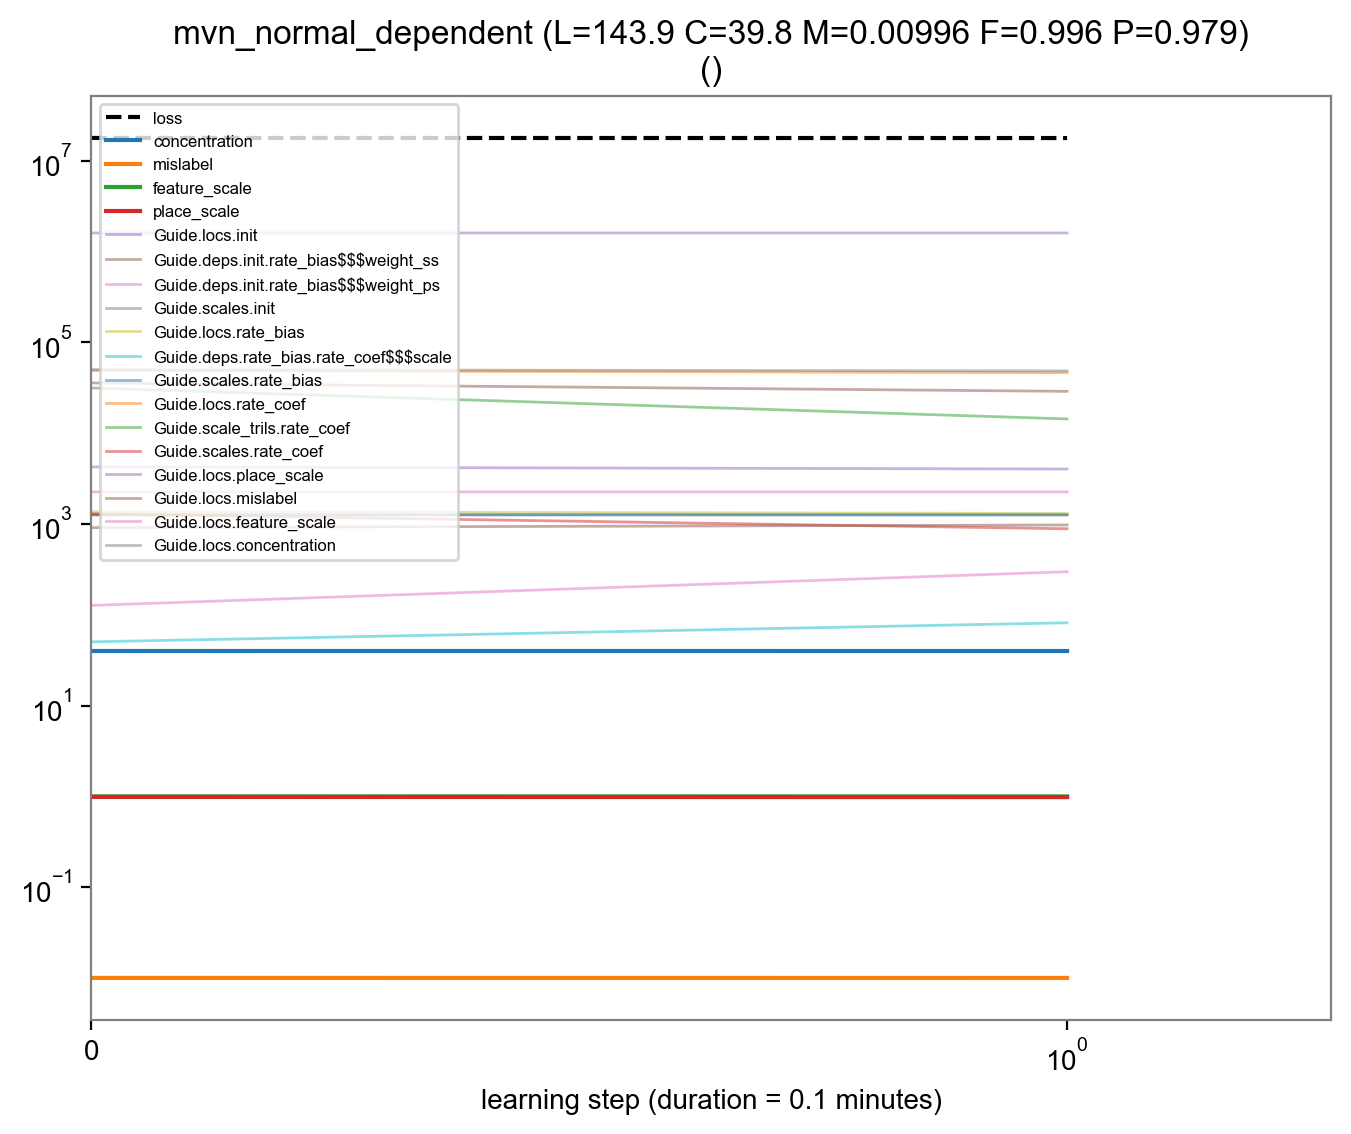

In [41]:
def plot_fits():
    num_nonzero = int(torch.count_nonzero(weekly_strains))
    for key, fit in fits.items():
        median = fit["median"]
        plt.figure(figsize=(8, 6))
        plt.plot(fit["losses"], "k--", label="loss")
        for name, series in fit.get("series", {"loss": fit["losses"]}).items():
            if name == "loss":
                continue
            elif name.startswith("Guide."):
                plt.plot(series, lw=1, alpha=0.5, label=name, zorder=-1)
            else:
                plt.plot(series, label=name)
        plt.yscale("log")
        plt.xscale("symlog", linthresh=1)
        plt.xlim(0, len(fit["losses"]))
        plt.legend(loc="upper left", fontsize=6)
        plt.xlabel("learning step (duration = {:0.1f} minutes)".format(fit["walltime"]/60))
        plt.title("{} (L={:0.4g} C={:0.3g} M={:0.3g} F={:0.3g} P={:0.3g})\n{}"
        .format(
            key[0],
            np.median(fit["losses"][-201:]) / num_nonzero,
            float(median["concentration"]),
            float(median.get("mislabel", 0)),
            float(median["feature_scale"]),
            float(median.get("place_scale", 0)),
            key[-1],
        ))
plot_fits()

## Interpreting results

England matched 1 regions
USA matched 57 regions
India matched 33 regions


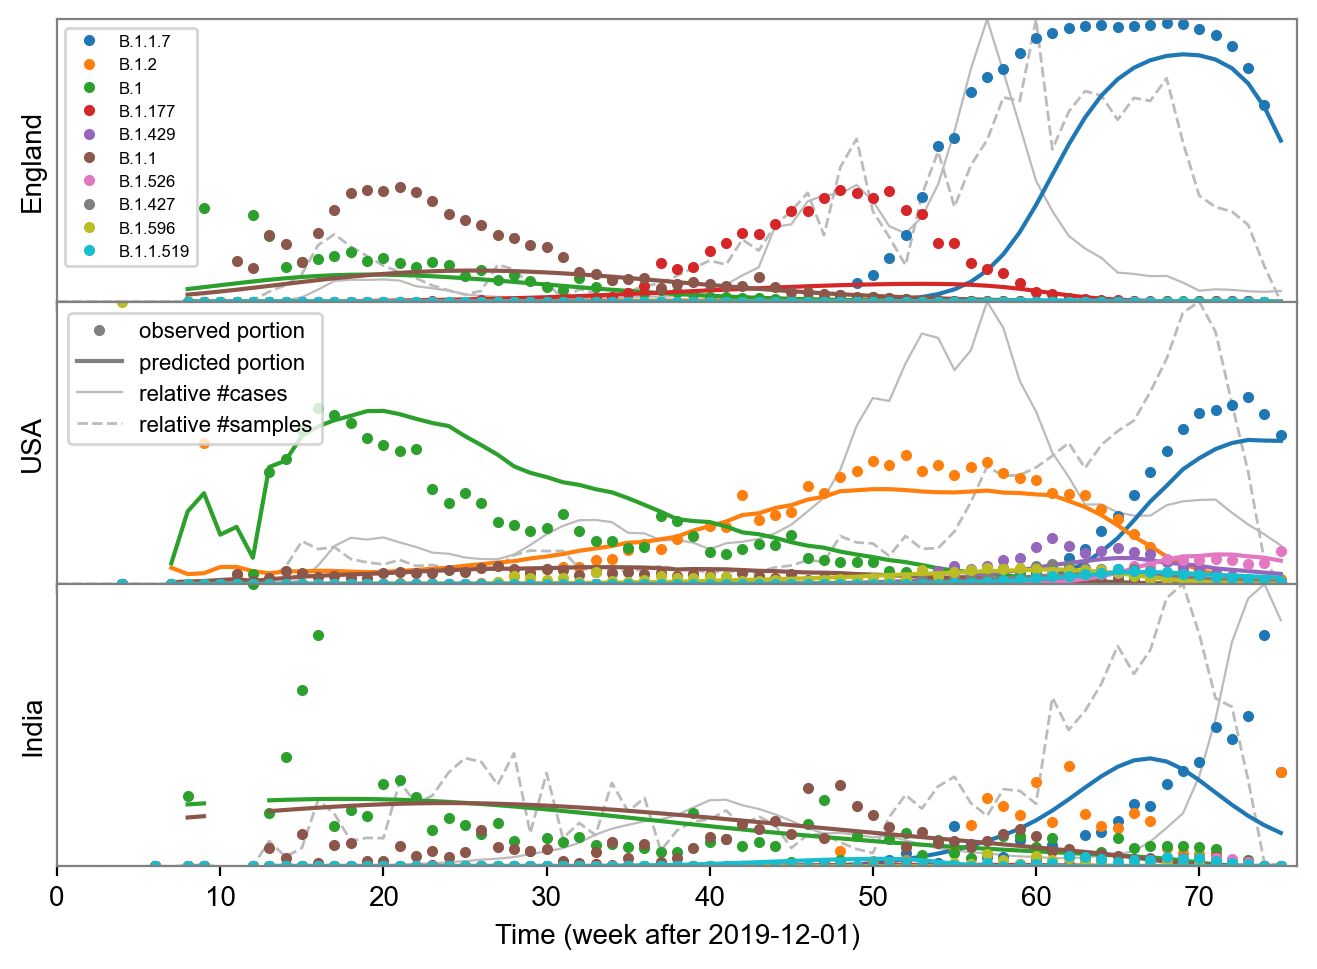

In [13]:
def plot_forecast(fit, queries, num_strains=5, months_ahead=3):
    if isinstance(queries, str):
        queries = [queries]
    fig, axes = plt.subplots(len(queries), figsize=(8, 1 + 1.5 * len(queries)), sharex=True)
    rate = fit["median"]["rate"]
    init = fit["median"]["init"]
    local_time = dataset["local_time"]
    probs = (init + rate * local_time[:, :, None]).softmax(-1)  # [T, P, S]
    predicted = probs * weekly_cases[:, :, None]  # [T, P, S]
    ids = torch.tensor([i for name, i in location_id.items()
                        if any(q in name for q in queries)])
    strain_ids = weekly_strains[:, ids].sum([0, 1]).sort(-1, descending=True).indices
    strain_ids = strain_ids[:num_strains]
    others = torch.full(weekly_strains.shape[-1:], True)
    others[strain_ids] = False
    colors = [f"C{i}" for i in range(10)] + ["black"] * 90
    assert len(colors) >= num_strains
    light = "#bbbbbb"
    for row, (query, ax) in enumerate(zip(queries, axes)):
        ids = torch.tensor([i for name, i in location_id.items() if query in name])
        print(f"{query} matched {len(ids)} regions")
        counts = weekly_cases[:, ids].sum(1)
        counts /= counts.max()
        ax.plot(counts, "k-", color=light, lw=0.8)
        counts = weekly_strains[:, ids].sum([1, 2])
        counts /= counts.max()
        ax.plot(counts, "k--", color=light, lw=1)
        pred = predicted[:, ids].sum(1)
        pred /= pred.sum(-1, True)
        obs = weekly_strains[:, ids].sum(1)
        obs /= obs.sum(-1, True)
        for s, color in zip(strain_ids, colors):
            ax.plot(pred[:, s], color=color)
            strain = lineage_id_inv[s]
            ax.plot(obs[:, s], color=color, lw=0, marker='o', markersize=3,
                    label={"Q": "B.1.1.7"}.get(strain, strain) if row == 0 else None)
        ax.set_ylim(0, 1)
        ax.set_yticks(())
        ax.set_ylabel(query)
        ax.set_xlim(0, len(weekly_strains))
        if row == len(axes) - 1:
            ax.set_xlabel("Time (week after 2019-12-01)")
        if row == 0:
            ax.legend(loc="upper left", fontsize=6)
        elif row == 1:
            ax.plot([], lw=0, marker='o', markersize=3, color='gray',
                    label="observed portion")
            ax.plot([], color='gray', label="predicted portion")
            ax.plot([], "k-", color=light, lw=0.8, label="relative #cases")
            ax.plot([], "k--", color=light, lw=1, label="relative #samples")
            ax.legend(loc="upper left", fontsize=8)
    plt.subplots_adjust(hspace=0)

plot_forecast(best_fit,
              queries=["England", "USA", "India"],
              num_strains=10)

In [14]:
def scatter_england(fit, strain):
    s = lineage_id[pangolin.compress(strain)]
    ids = torch.tensor([i for name, i in location_id.items() if "England" in name])
    if len(ids) > 1:
        init = fit["median"]["init"][ids, s]
        rate = fit["median"]["rate"][ids, s]
        plt.figure(figsize=(6,5))
        plt.scatter(init.numpy(), rate.numpy(), alpha=0.5, lw=0)
    
scatter_england(best_fit, "B.1.1.7")
scatter_england(best_fit, "B.40")

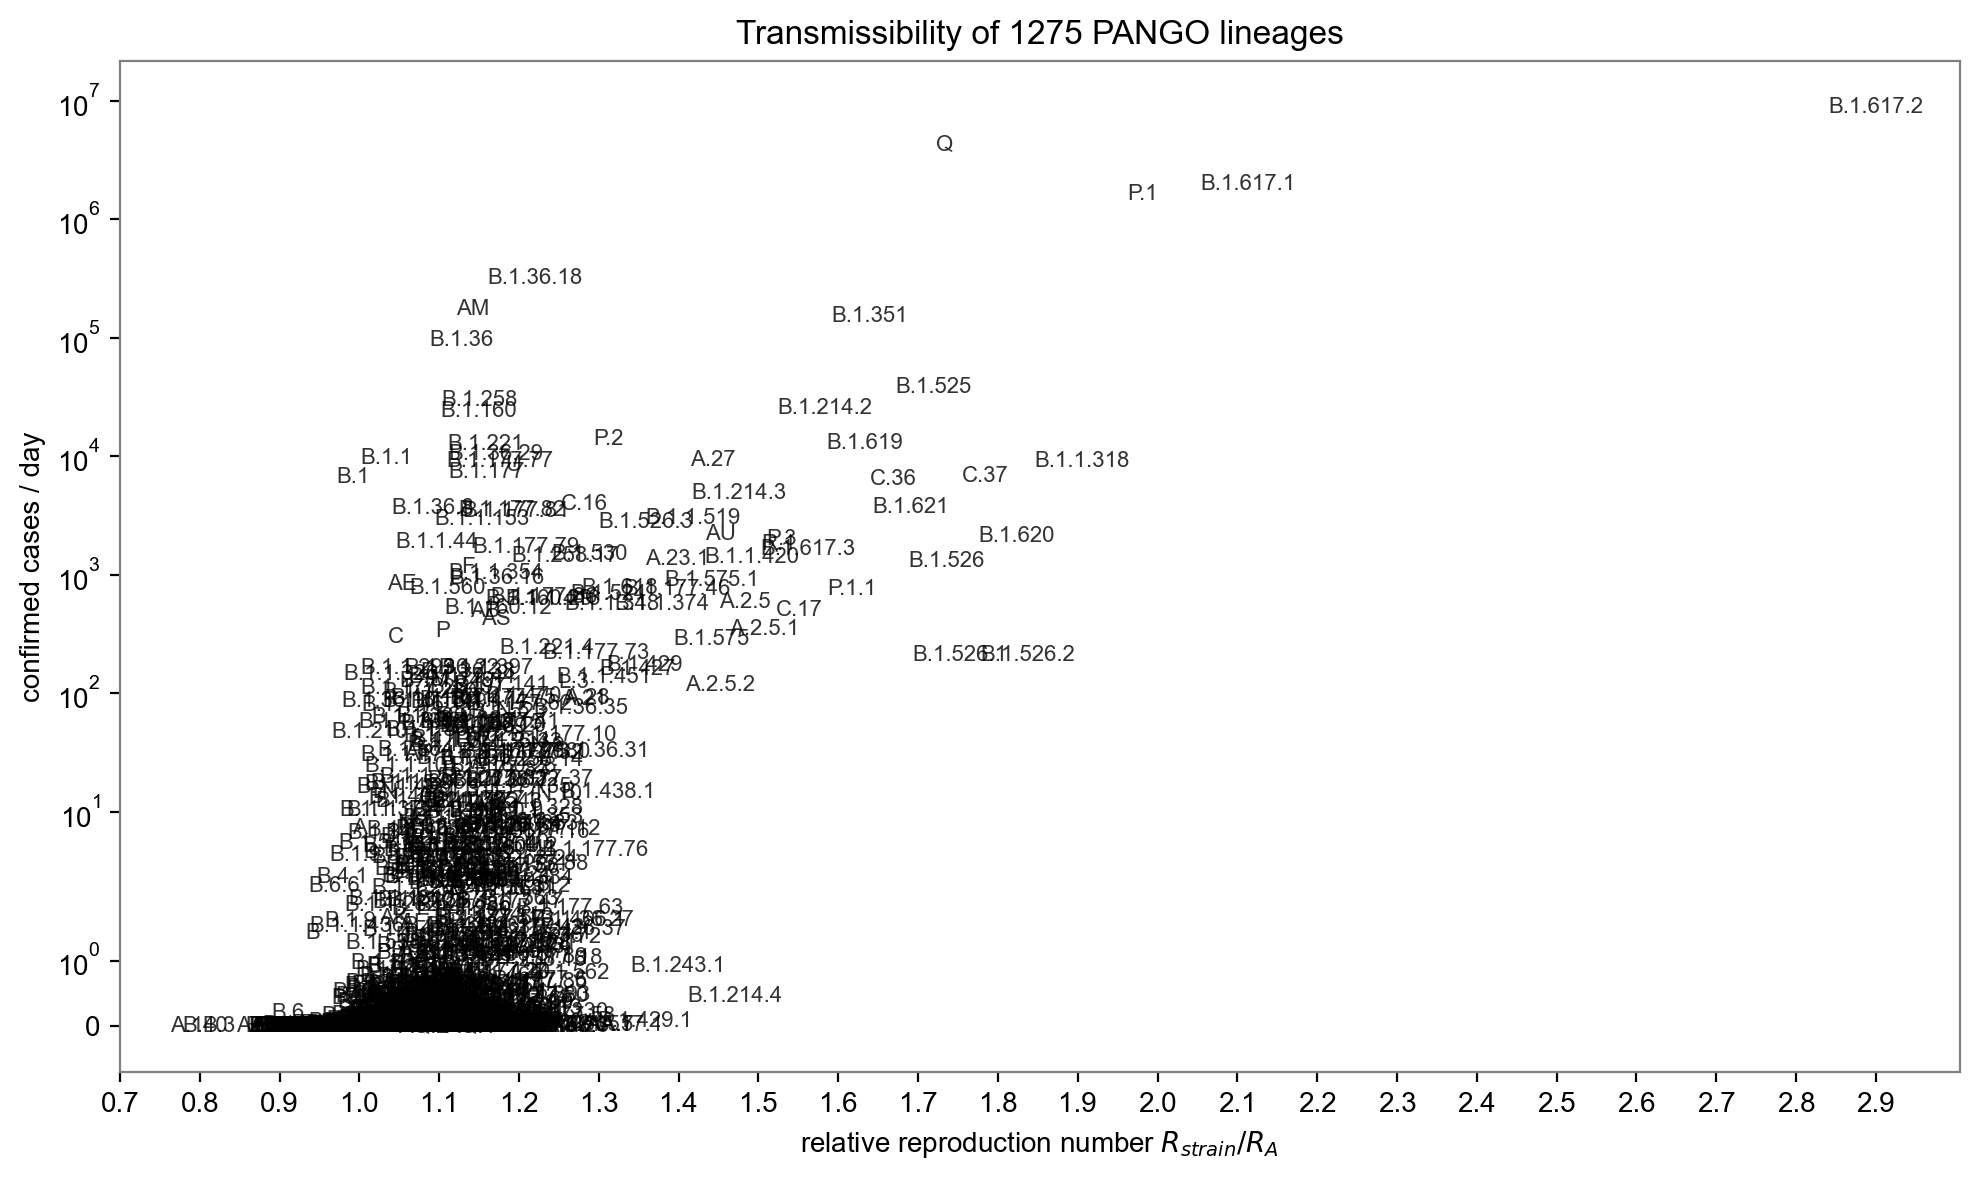

In [15]:
def plot_prevalence(fit, filenames=()):
    rate = fit["median"]["rate"].median(0).values
    rate = rate - rate[lineage_id["A"]]
    R = rate.exp()
    init = fit["median"]["init"] + dataset["local_time"][-2, :, None] * rate
    init = init - init.logsumexp(-1, True)
    cases = torch.einsum("ps,p->s", init.exp(), weekly_cases[-2])
    cases = cases / mutrans.TIMESTEP
    plt.figure(figsize=(10, 6))
    plt.scatter(R, cases, lw=0, alpha=0)
    for name, i in lineage_id.items():
        plt.text(R[i], cases[i], name, fontsize=8, alpha=0.8,
                 horizontalalignment="center", verticalalignment="center",)
    plt.ylabel("confirmed cases / day")
    plt.yscale("symlog")
    #plt.xscale("log")
    #plt.ylim(1, None)
    plt.xlim(0.9, None)
    lb10 = math.floor(10 * R.min().item())
    ub10 = math.ceil(10 * R.max().item())
    xticks = [x10 / 10 for x10 in range(lb10, ub10 + 1)]
    plt.xticks(xticks, list(map(str, xticks)))
    plt.xlabel("relative reproduction number $R_{strain} / R_A$")
    plt.title(f"Transmissibility of {len(lineage_id)} PANGO lineages")
    plt.tight_layout()
    for filename in filenames:
        plt.savefig(filename)

plot_prevalence(best_fit, ["paper/strain_prevalence.png"])

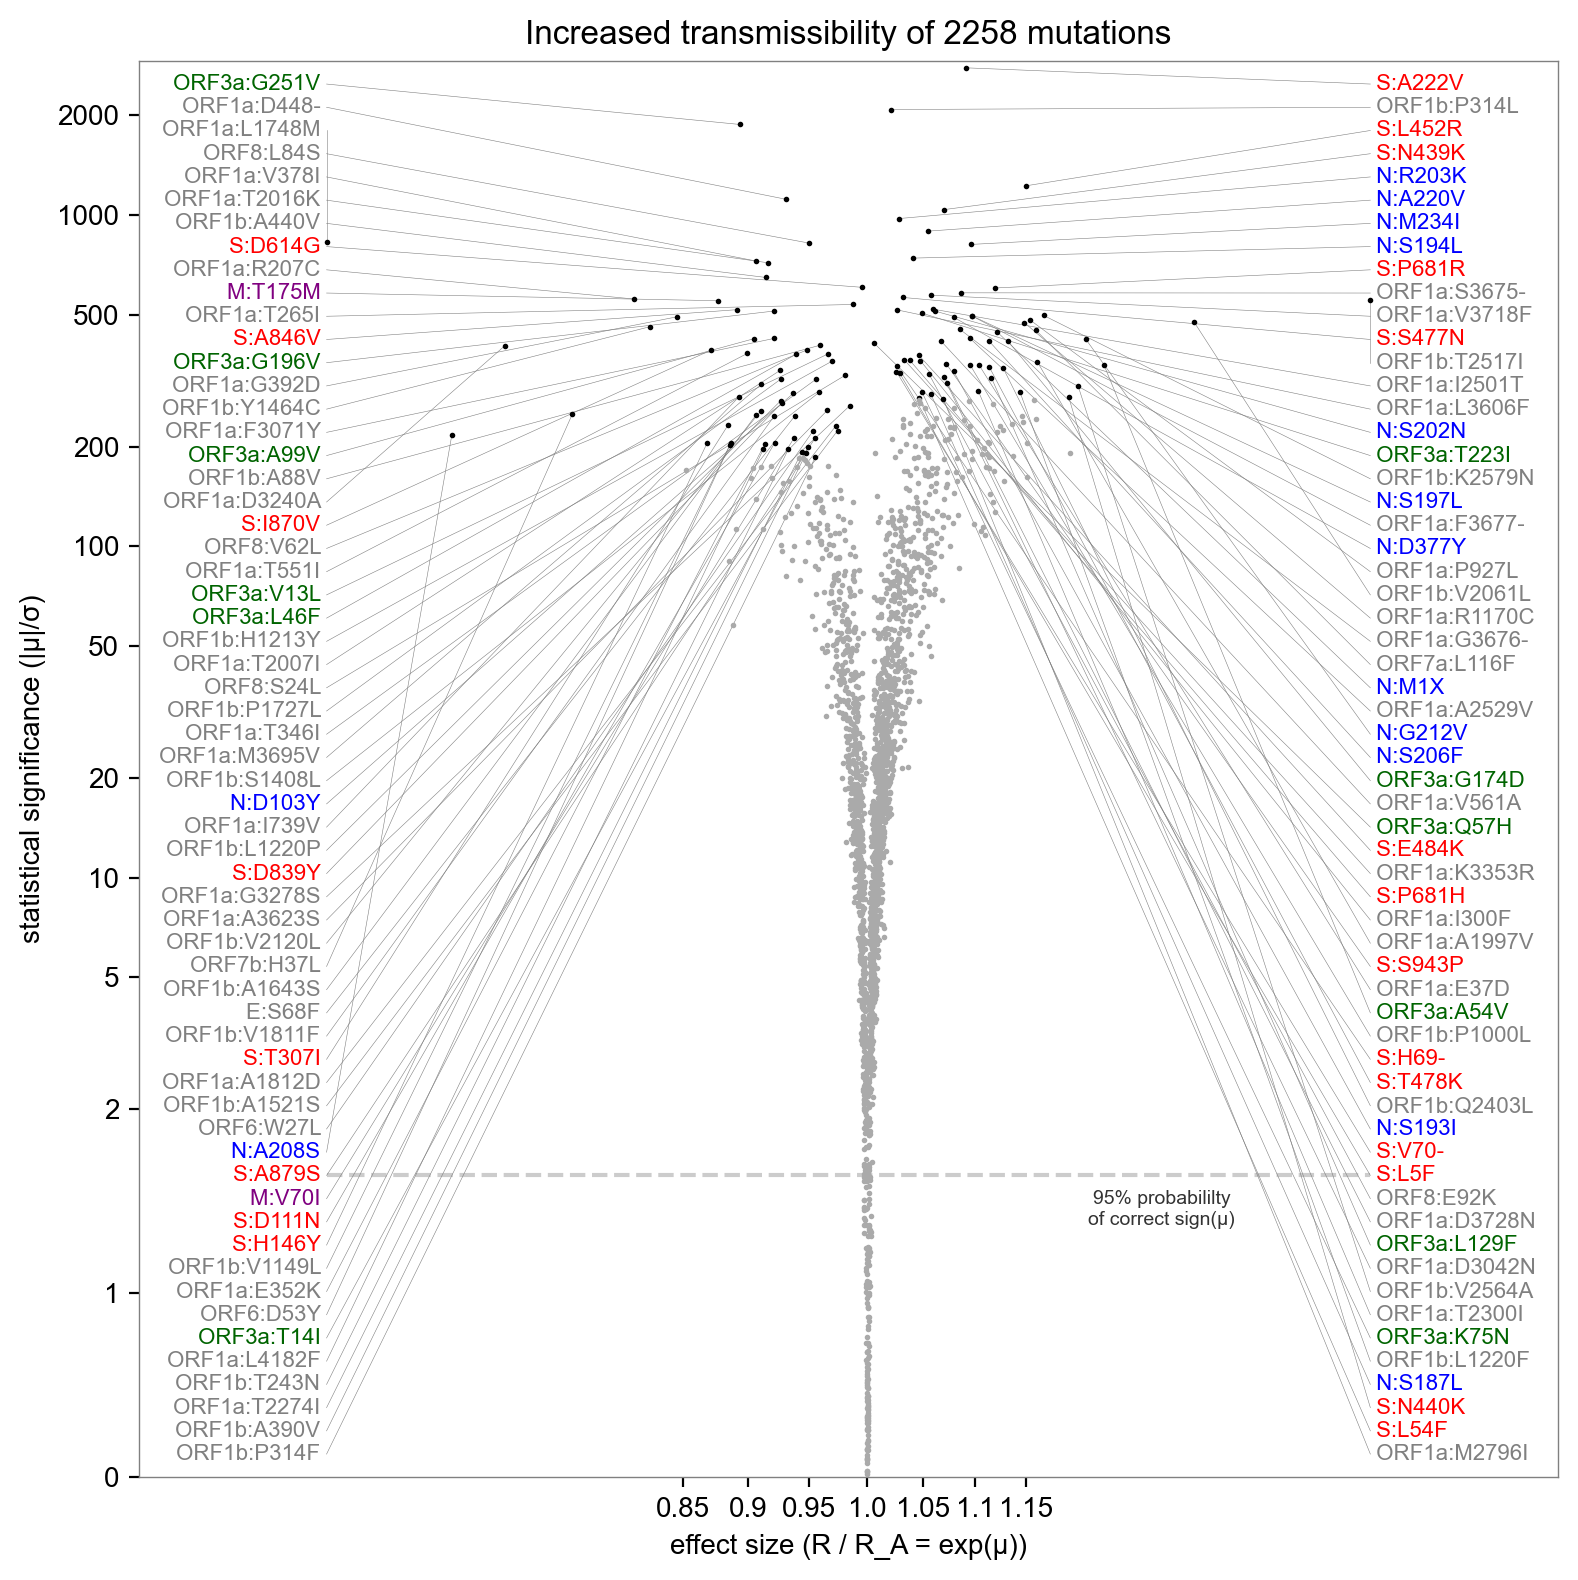

In [16]:
def plot_volcano(mean, std, filenames=(), linthresh=2, top_k=60):
    xs = mean
    ys = mean.abs() / std
    assert len(xs) == len(mutations)
    y0, y1 = float(ys.min()), float(ys.max())
    x0, x1 = float(xs.min()), float(xs.max())
    ys, idx = ys.sort(0, descending=True)
    xs = xs[idx]
    pos = (0 < xs) & (xs < math.inf)
    neg = (-math.inf < xs) & (xs < 0)
    ys_pos, ys_neg = ys[pos], ys[neg]
    xs_pos, xs_neg = xs[pos], xs[neg]
    idx_pos, idx_neg = idx[pos], idx[neg]
    N = top_k

    plt.figure(figsize=(8, 8))
    plt.title(f"Increased transmissibility of {len(mutations)} mutations")
    for mask in [pos, neg]:
        xs_mask, ys_mask = xs[mask], ys[mask]
        plt.plot(xs_mask[:N], ys_mask[:N], 'k.', lw=0, markersize=2, zorder=10)
        plt.plot(xs_mask[N:], ys_mask[N:], 'k.', lw=0, markersize=2, zorder=10, color="#aaa")
    plt.xlabel("effect size (R / R_A = exp(μ))")
    xticks = [0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15]
    plt.xticks(list(map(math.log, xticks)), list(map(str, xticks)))
    plt.ylabel("statistical significance (|μ|/σ)")
    lpad = 0.33 if any("," in mutations[i] for i in idx_neg[:N].tolist()) else 0.18
    rpad = 0.33 if any("," in mutations[i] for i in idx_pos[:N].tolist()) else 0.18
    plt.xlim(x0 - (x1 - x0) * lpad, x1 + (x1 - x0) * rpad)
    plt.ylim(0, None)
    plt.yscale("symlog", linthresh=linthresh)
    yticks = [y for y in [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000] if y < y1]
    plt.yticks(yticks, list(map(str, yticks)))
    p95 = dist.Normal(0, 1).icdf(torch.tensor(0.95)).item()
    plt.plot([x0, x1], [p95, p95], 'k--', alpha=0.2)
    plt.text(0.2 * x0 + 0.8 * x1, p95 * 0.95, "95% probabililty\nof correct sign(μ)",
             fontsize=7, horizontalalignment="center", verticalalignment="top",
             alpha=0.8, zorder=100)
        
    colors = {"N": "blue", "S": "red", "M": "purple", "ORF3a": "darkgreen"}
    ax = plt.gca()
    t = (ax.transScale + ax.transLimits).inverted()
    for i in range(N):
        x = x0
        _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
        plt.plot([x, xs_neg[i]], [y, ys_neg[i]], color='gray', lw=0.2)
        name = mutations[int(idx_neg[i])]
        plt.text(x, y, name + " ", color=colors.get(name.split(":")[0], "gray"),
                 fontsize=8, verticalalignment="center", horizontalalignment="right")
    for i in range(N):
        x = x1
        _, y = t.transform((0, 1 - (i + 1) / (N + 1)))
        name = mutations[int(idx_pos[i])]
        plt.plot([x, xs_pos[i]], [y, ys_pos[i]], color='gray', lw=0.2)
        plt.text(x, y, " " + name, color=colors.get(name.split(":")[0], "gray"),
                 fontsize=8, verticalalignment="center", horizontalalignment="left")
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
    plt.tight_layout()
    for f in filenames:
        plt.savefig(f)

plot_volcano(best_fit["mean"]["rate_coef"], best_fit["std"]["rate_coef"], linthresh=2,
             filenames=["paper/volcano.png"])

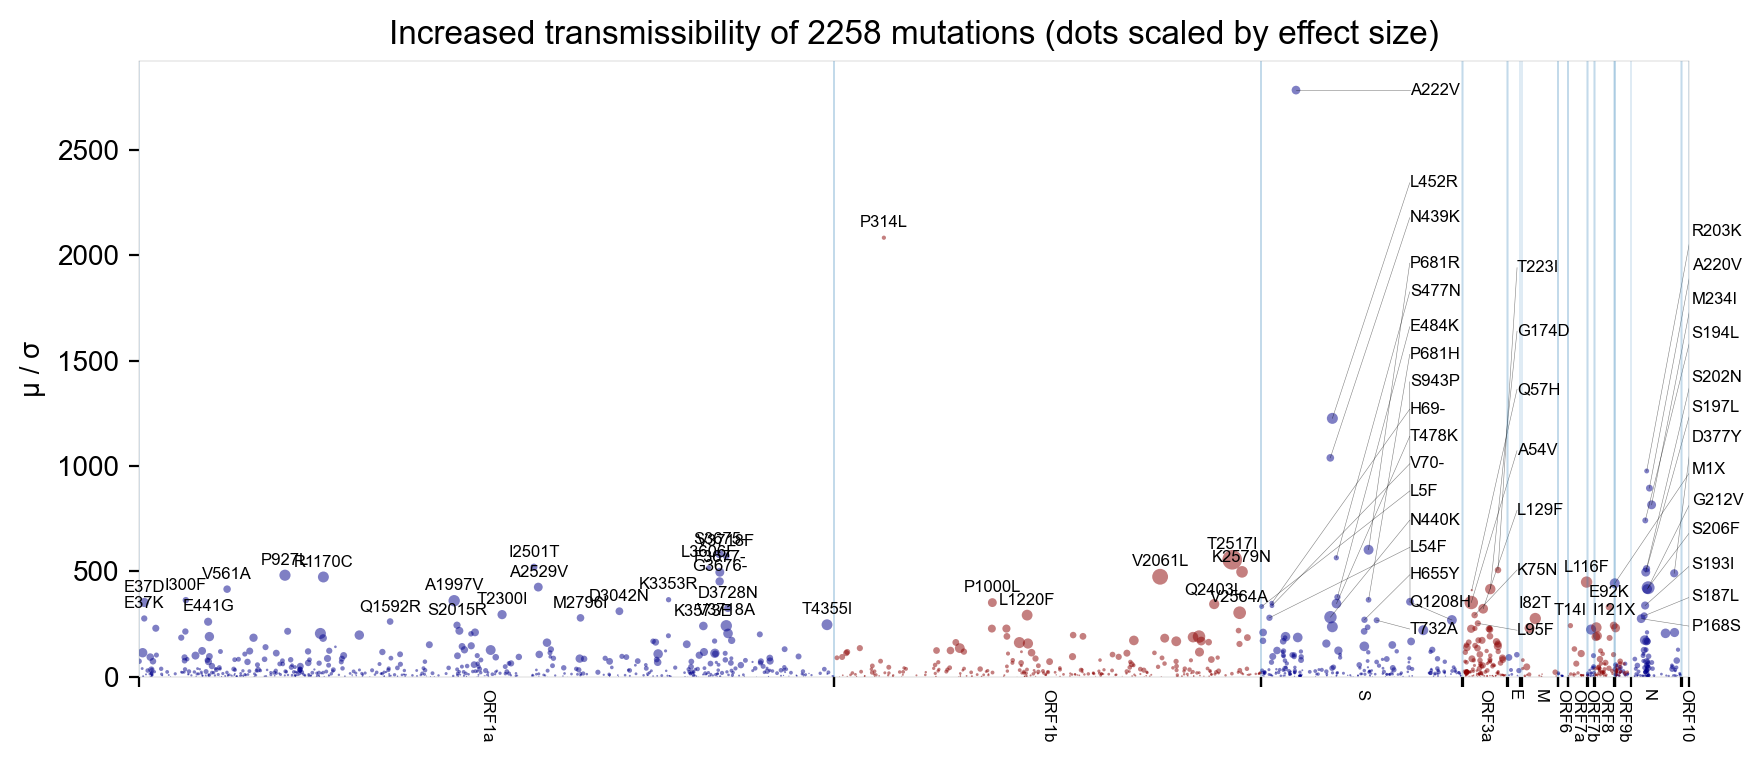

In [17]:
from pyrocov.sarscov2 import GENE_TO_POSITION, aa_mutation_to_position

def plot_manhattan(mean, std, top_k=75, filenames=()):
    sigma = mean / std.clamp(min=1e-8)
    y1 = sigma.max().item()
    position = torch.tensor([aa_mutation_to_position(m) for m in mutations])
    assert len(mean) == len(mutations)
    gene_id = {gene_name: i for i, gene_name in enumerate(GENE_TO_POSITION)}
    gene_ids = torch.tensor([gene_id[m.split(":")[0]] for m in mutations])
    even = (gene_ids % 2 == 0) & (mean > 0)
    odd = (gene_ids % 2 == 1) & (mean > 0)

    plt.figure(figsize=(10, 4))
    plt.title(f"Increased transmissibility of {len(mutations)} mutations"
              " (dots scaled by effect size)")
    mean_scale = 50 / mean.max().item()
    for mask, color in zip([even, odd], ["darkblue", "darkred"]):
        plt.scatter(position[mask].numpy(), sigma[mask].numpy(),
                    mean_scale * mean[mask].numpy(), color=color, alpha=0.5, lw=0)
    special = {"S": [], "N": [], "ORF3a": []}  # Many hits, plot with lines
    for i in sigma.sort(0, descending=True).indices[:top_k].tolist():
        x = float(position[i])
        y = float(sigma[i])
        gene, name = mutations[i].split(":")
        if gene in special:
            special[gene].append((y, x, name))
            continue
        plt.text(x, y + y1/80, name, fontsize=6,
                 verticalalignment="bottom", horizontalalignment="center")
    for special_ in special.values():
        special_.sort(reverse=True)
    y_bounds = {k: (min(y for (y, _, _) in v), max(y for (y, _, _) in v))
                for k, v in special.items() if v}
    for i, (y, x, name) in enumerate(special["S"]):
        lb, ub = y_bounds["S"]
        lb, ub = lb * 0.8, ub * 0.1 + y1 * 0.9
        y_label = 0.2 * y + 0.8 * (ub + (lb - ub) * (i / (len(special["S"]) - 0.99)))
        x_label = GENE_TO_POSITION["S"][1] - 1000
        plt.text(x_label, y_label, name, fontsize=6,
                 verticalalignment="center", horizontalalignment="left")
        plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
    for gene in ["N", "ORF3a"]:
        for i, (y, x, name) in enumerate(special[gene]):
            lb, ub = y_bounds[gene]
            lb, ub = lb * 0.8, ub * 0.1 + y1 * 0.9
            y_label = 0.3 * y + 0.7 * (ub + (lb - ub) * (i / (len(special[gene]) - 0.99)))
            x_label = GENE_TO_POSITION[gene][1] + 200
            plt.text(x_label, y_label, name, fontsize=6,
                     verticalalignment="center", horizontalalignment="left")
            plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
        
    start_end = list(GENE_TO_POSITION.values())
    plt.xlim(start_end[0][0], start_end[-1][-1])
    xticks = []
    for i, (gene, (start, end)) in enumerate(GENE_TO_POSITION.items()):
        if gene == "ORF14":
            continue  # skip overlapping frame
        plt.axvline(start, lw=0.1)
        plt.axvline(end, lw=0.1)
        xticks.extend([start, end])
        plt.text((start + end) / 2, -y1 / 50, gene, rotation=-90,
                 fontsize=6, verticalalignment="top", horizontalalignment="center")
    plt.xticks(xticks, labels=())
    plt.ylim(0, None)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.1)
    plt.ylabel("μ / σ")
    for f in filenames:
        plt.savefig(f)

plot_manhattan(best_fit["mean"]["rate_coef"], best_fit["std"]["rate_coef"],
               filenames=["paper/manhattan.png"])

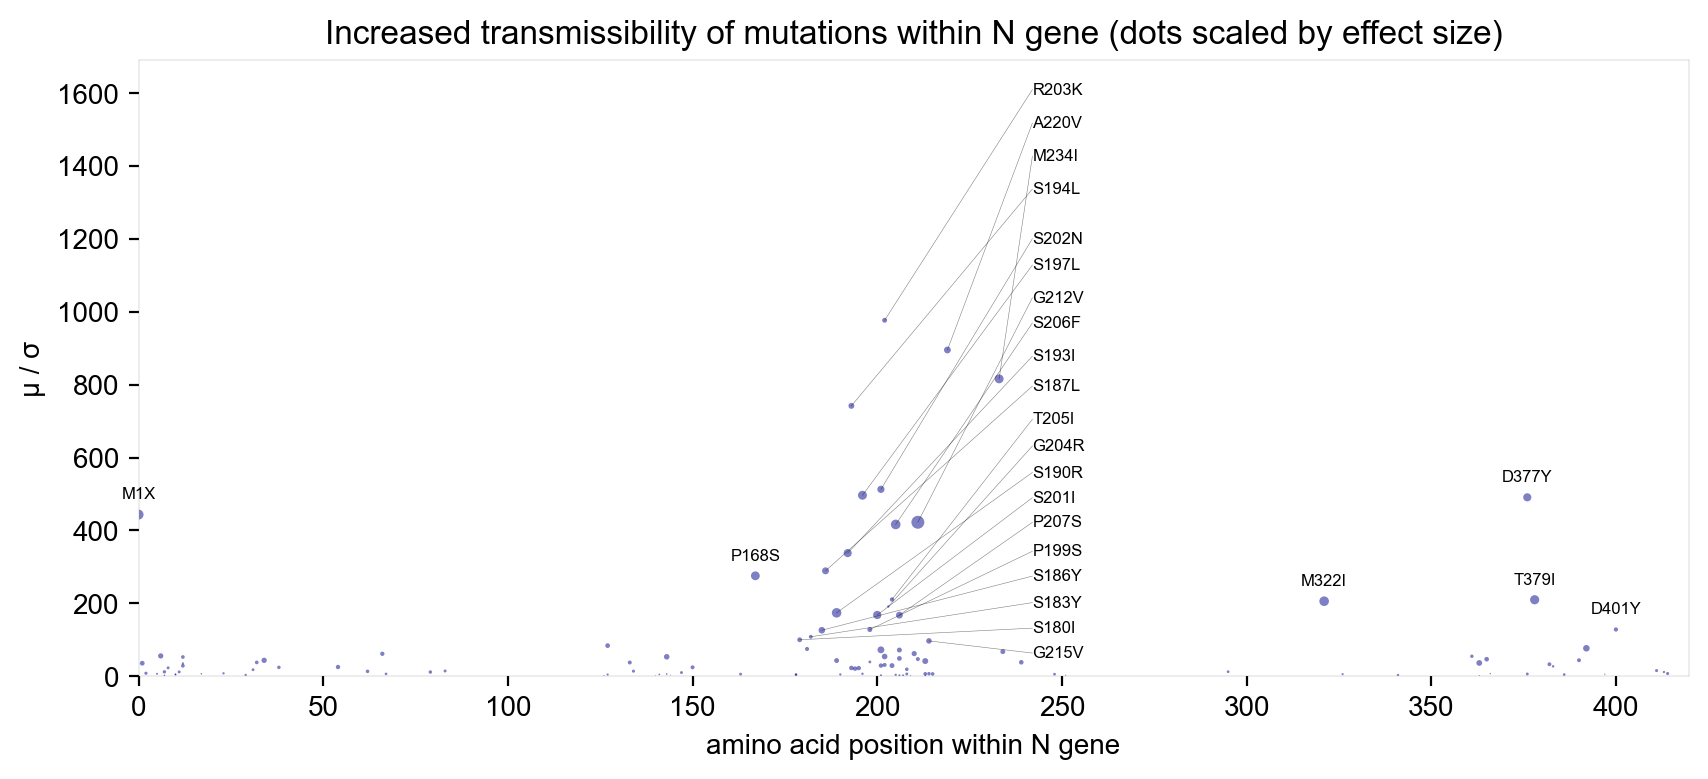

In [18]:
def plot_upper_east_side(mean, std, top_k=120, filenames=()):
    sigma = mean / std.clamp(min=1e-8)
    y1 = sigma.max().item()
    position = torch.tensor([aa_mutation_to_position(m) for m in mutations])
    assert len(mean) == len(mutations)
    gene_id = {gene_name: i for i, gene_name in enumerate(GENE_TO_POSITION)}
    gene_ids = torch.tensor([gene_id[m.split(":")[0]] for m in mutations])
    mask = (gene_ids == gene_id["N"]) & (mean > 0)

    plt.figure(figsize=(10, 4))
    plt.title(f"Increased transmissibility of mutations within N gene"
              " (dots scaled by effect size)")
    mean_scale = 50 / mean.max().item()
    plt.scatter(position[mask].numpy(), sigma[mask].numpy(),
                mean_scale * mean[mask].numpy(), color="darkblue", alpha=0.5, lw=0)
    special = []  # Many hits, plot with lines
    z0 = 28800
    z1 = 29000
    for i in sigma.sort(0, descending=True).indices[:top_k].tolist():
        x = float(position[i])
        y = float(sigma[i])
        gene, name = mutations[i].split(":")
        if gene != "N":
            continue
        if z0 < x < z1:
            special.append((y, x, name))
        else:
            plt.text(x, y + y1/80, name, fontsize=6,
                     verticalalignment="bottom", horizontalalignment="center")
    special.sort(reverse=True)
    lb = min(y for (y, _, _) in special)
    ub = max(y for (y, _, _) in special)
    lb, ub = lb * 0.5, ub * 0.5 + y1 * 0.5
    for i, (y, x, name) in enumerate(special):
        y_label = 0.3 * y + 0.7 * (ub + (lb - ub) * (i / (len(special) - 0.99)))
        x_label = z1
        plt.text(x_label, y_label, name, fontsize=6,
                 verticalalignment="center", horizontalalignment="left")
        plt.plot([x, x_label], [y, y_label], 'k-', lw=0.2, alpha=0.5)
    start, end = GENE_TO_POSITION["N"]
    plt.xlim(start, end)
    xticks = [start]
    while xticks[-1] + 150 < end:
        xticks.append(xticks[-1] + 150)
    labels = [str((x - start) // 3) for x in xticks]
    plt.xticks(xticks, labels)
    plt.xlabel("amino acid position within N gene")
    plt.ylim(0, None)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(0.1)
    plt.ylabel("μ / σ")
    for f in filenames:
        plt.savefig(f)

plot_upper_east_side(best_fit["mean"]["rate_coef"], best_fit["std"]["rate_coef"],
                     filenames=["paper/upper_east_side.png"], top_k=250)

## Extracting a table of top mutations and their stories

In [19]:
def rank_mutations(fit, names):
    mean = fit["mean"]["rate_coef"]
    std = fit["std"]["rate_coef"]
    sigma = mean / std.clamp(min=1e-8)
    ranks = sigma.sort(0, descending=True).indices.tolist()
    assert len(ranks) == len(mutations)
    ranked = [mutations[k] for k in ranks]
    ranks = {m: i for i, m in enumerate(ranked)}
    print("Mut'n\tRank\tEstimate")
    for name in names:
        i = mutations.index(name)
        print("{}\t{}\t{:0.3g} ± {:0.2g}".format(name, ranks[name], mean[i], std[i]))

rank_mutations(best_fit, ["S:D614G", "S:N501Y", "S:E484K", "S:L452R"])

Mut'n	Rank	Estimate
S:D614G	2250	-0.00437 ± 7.2e-06
S:N501Y	220	0.0162 ± 0.00015
S:E484K	33	0.0453 ± 0.00012
S:L452R	2	0.14 ± 0.00011


In [20]:
parent_features = torch.zeros_like(features)
for c, child in enumerate(lineage_id_inv):
    child = pangolin.decompress(child)
    parent = child
    while True:
        parent = "A" if parent == "A" else pangolin.get_parent(parent)
        try:
            p = lineage_id[pangolin.compress(parent)]
            break
        except KeyError:
            continue
    parent_features[c] = features[p]

In [21]:
def find_emergences(i):
    delta = features[:, i] - parent_features[:, i]
    emerged = set((delta > 0.5).nonzero(as_tuple=True)[0].tolist())
    emerged.add(delta.argmax().item())
    result = []
    for k in sorted(emerged):
        name = lineage_id_inv[k]
        longname = pangolin.decompress(name)
        result.append(name if name == longname else f"{name} ({longname})")
    return result

In [22]:
def write_mutation_table(fit, filename):
    assert filename.endswith(".tsv")
    mean = fit["mean"]["rate_coef"]
    std = fit["std"]["rate_coef"]
    sigma = mean / std.clamp(min=1e-8)
    if "samples" in fit:
        lb, ub = stats.confidence_interval(0.95, fit["samples"]["rate_coef"])
    else:
        lb, ub = dist.Normal(mean, std).icdf(torch.tensor([0.025, 0.975])[:, None])
    R_RA = mean.exp()  # mean is in units of generation time.
    lineage_counts = weekly_strains.sum((0, 1))
    schema = [
        ("rank", "{:d}"),
        ("mutation", "{:s}"),
        ("mean/stddev", "{:0.6g}"),
        ("mean", "{:0.6g}"),
        ("95% ci lower", "{:0.6g}"),
        ("95% ci upper", "{:0.6g}"),
        ("R / R_A", "{:0.6g}"),
        ("emerged in lineages", "{:s}"),  
    ]
    header = "\t".join(h for h, r in schema) + "\n"
    row = "\t".join(r for h, r in schema) + "\n"
    with open(filename, "wt") as f:
        f.write(header)
        for rank, i in enumerate(sigma.sort(0, descending=True).indices.tolist()):
            emerged = find_emergences(i)
            f.write(row.format(
                rank + 1, mutations[i],
                sigma[i], mean[i], lb[i], ub[i], R_RA[i], ", ".join(emerged)
            ))

write_mutation_table(best_fit, "paper/mutations.tsv")
pd.read_csv("paper/mutations.tsv", sep="\t")

,rank,mutation,mean/stddev,mean,95% ci lower,95% ci upper,R / R_A,emerged in lineages
0,1,S:A222V,2784.070,0.087433,0.087371,0.087494,1.091370,"B.1.160.30, B.1.177, B.1.36.31"
1,2,ORF1b:P314L,2083.580,0.020485,0.020466,0.020504,1.020700,"B.1, B.59, B.6.7"
2,3,S:L452R,1226.250,0.139981,0.139758,0.140205,1.150250,"A.2.5, A.21, A.27, C.16 (B.1.1.1.16), C.17 (B...."
3,4,S:N439K,1038.840,0.067242,0.067115,0.067369,1.069550,"B.1.222, B.1.258, B.1.466.1, AU (B.1.466.2), B..."
4,5,N:R203K,976.593,0.027791,0.027735,0.027846,1.028180,"B.1.1, B.1.164, B.1.173, B.1.218, B.1.531, B.1..."
...,...,...,...,...,...,...,...,...
2253,2254,ORF1a:V378I,-727.351,-0.098714,-0.098980,-0.098448,0.906002,B.4
2254,2255,ORF8:L84S,-823.420,-0.051434,-0.051556,-0.051312,0.949866,B.1.247
2255,2256,ORF1a:L1748M,-827.709,-0.477479,-0.478610,-0.476348,0.620345,B.1.235
2256,2257,ORF1a:D448-,-1117.340,-0.072318,-0.072445,-0.072191,0.930235,"C.23 (B.1.1.1.23), B.10, B.11, B.15, B.23, B.2..."


In [23]:
print(columns.keys())

dict_keys(['lineage', 'virus_name', 'accession_id', 'collection_date', 'location', 'add_location', 'day'])


In [24]:
def estimate_lineage_bdays(exclude_first=10):
    lineage_days = defaultdict(list)
    for lineage, day in zip(columns["lineage"], columns["day"]):
        lineage = pangolin.decompress(lineage)
        lineage_days[lineage].append(day)
    lineage_bday = {}
    for lineage, days in list(lineage_days.items()):
        days.sort()
        lineage_bday[lineage] = days[min(exclude_first, len(days) // 10)]
    start_date = datetime.datetime.strptime(mutrans.START_DATE, "%Y-%m-%d")
    return {
        lineage: (start_date + datetime.timedelta(days=day)).strftime("%Y-%m-%d")
        for lineage, day in lineage_bday.items()
    }

lineage_bday = estimate_lineage_bdays()

In [25]:
def write_strain_table(fit, filename):
    assert filename.endswith(".tsv")
    R_mean = fit["median"]["rate"].exp()
    R_sample = fit["samples"]["rate"].exp()
    RA = R_mean[lineage_id["A"]].item()
    R_RA = R_mean / RA
    lb, ub = stats.confidence_interval(0.95, R_sample / RA)
    logits = fit["median"]["init"] + dataset["local_time"][..., None] * fit["median"]["rate"]
    probs = (logits - logits.logsumexp(-1, True)).exp()
    cases = torch.einsum("tps,tp->ts", probs, weekly_cases)
    cases_per_day = cases[-2] / mutrans.TIMESTEP
    cases_total = cases.sum(0)
    schema = [
        ("rank", "{:d}"),
        ("strain", "{:s}"),
        ("R / R_A", "{:.6g}"),
        ("95% ci lower", "{:.6g}"),
        ("95% ci upper", "{:.6g}"),
        ("confirmed cases / day", "{:.6g}"),
        ("confirmed cases total", "{:.6g}"),
        ("birthday", "{:s}"),
    ]
    header = "\t".join(h for h, r in schema) + "\n"
    row = "\t".join(r for h, r in schema) + "\n"
    with open(filename, "wt") as f:
        f.write(header)
        for rank, i in enumerate(R_RA.sort(0, descending=True).indices.tolist()):
            lineage = lineage_id_inv[i]
            f.write(row.format(
                rank + 1, lineage,
                R_RA[i], lb[i], ub[i], cases_per_day[i], cases_total[i],
                lineage_bday[pangolin.decompress(lineage)],
            ))

write_strain_table(best_fit, "paper/strains.tsv")
pd.read_csv("paper/strains.tsv", sep="\t")

KeyError: 'samples'

## Comparison with deep mutational scans

We first compare with [(Starr et al. 2020)](https://www.sciencedirect.com/science/article/pii/S0092867420310035) who study S mutations affecting folding and ACE2 binding.

In [ ]:
df = pd.read_csv("data/mutation-studies/1-s2.0-S0092867420310035-mmc2.csv")
df

In [ ]:
folding = {f"S:{m}": float(e) for m, e in zip(df["mutation"], df["expr_avg"])}
binding = {f"S:{m}": float(b) for m, b in zip(df["mutation"], df["bind_avg"])}
print(sum(1 for m in mutations if m in folding))

We next compare with [(Greaney et al. 2021)](https://www.sciencedirect.com/science/article/pii/S1931312820306247) who study antibody escape.

In [ ]:
df = pd.read_csv("data/mutation-studies/1-s2.0-S1931312820306247-mmc2.csv")
df

In [ ]:
escape = {
    f"S:{w}{s}{m}": float(e)
    for w, s, m, e in zip(df["wildtype"], df["site"], df["mutation"], df["mut_escape"])
}
print(sum(1 for m in mutations if m in escape))

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
ms = [m for m in mutations if m in escape]
y = best_fit["mean"]["rate_coef"][[i for i, m in enumerate(mutations) if m in escape]].numpy()
axes[0].set_ylabel("Δ log R")
for name, ax in zip(["folding", "binding", "escape"], axes):
    scan = locals()[name]
    x = torch.tensor([scan[m] for m in ms]).numpy()
    # ax.scatter(x, y, alpha=0.5, lw=0)
    for xm, ym, m in zip(x, y, ms):
        ax.text(xm, ym, m[2:], fontsize=6,
                verticalalignment="center", horizontalalignment="center")
    ax.set_xlim(1.08 * x.min() - 0.08 * x.max(), 1.08 * x.max() - 0.08 * x.min())
    ax.set_ylim(1.05 * y.min() - 0.05 * y.max(), 1.05 * y.max() - 0.05 * y.min())
    ax.set_xlabel(f"{name} (ρ = {correlation(x, y):0.2g})")
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)
axes[2].set_xscale("log")
axes[2].set_xlim(x.min() ** 1.08 / x.max() ** 0.08, x.max() ** 1.08 / x.min() ** 0.08)
axes[1].set_title(f"Comparison of {len(ms)} S gene mutations to deep scanning")
plt.subplots_adjust(wspace=0)

It's hard to say whether these correlations are meaningful, as they are dominated by a few outliers.

Let's fit a linear model regressing transmissibility against theses deep scanning results.

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal
from pyro.optim import Adam

def fit_model(fit):
    trans_data = fit["mean"]["rate_coef"][[i for i, m in enumerate(mutations) if m in escape]]
    folding_data = torch.tensor([folding[m] for m in ms])
    binding_data = torch.tensor([binding[m] for m in ms])
    escape_data = torch.tensor([escape[m] for m in ms])
    
    def model():
        coef = pyro.sample("coef", dist.Normal(0, 10).expand([5]).to_event(1))
        t, f, b, e, be = coef.unbind(-1)
        noise = pyro.sample("noise", dist.LogNormal(0, 2))
        with pyro.plate("data", len(trans_data)):
            pred = (
                t + f * folding_data + b * binding_data + e * escape_data
                + be * binding_data * escape_data
            )
            pyro.sample("trans", dist.Normal(pred, noise), obs=trans_data)

    pyro.clear_param_store()
    guide = AutoMultivariateNormal(model)
    elbo = Trace_ELBO(num_particles=100, vectorize_particles=True)
    svi = SVI(model, guide, Adam({"lr": 0.2}), elbo)
    for step in range(201):
        loss = svi.step()
        if step % 20 == 0:
            print(f"step {step} loss = {loss:0.4g}")
    loc, scale = guide._loc_scale()
    print("Model:")
    print("transmissibility = t + f folding + b binding + e escape + be binding escape")
    print("Learned coefficients:")
    for k, l, s in zip("t f b e be".split(), loc.tolist(), scale.tolist()):
        print(f"{k} = {l:0.4g} +- {s:0.2f}")
        
fit_model(best_fit)

## Fit on subsets of data

In [ ]:
print(Counter([n for n in columns["virus_name"] if "-CDC-2-" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "USA" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "United King" in n]).most_common(2))
print(Counter([n for n in columns["location"] if "North America " in n]).most_common(2))
print(Counter([n for n in columns["location"] if "Europe " in n]).most_common(2))

In [ ]:
holdout_fits = {k[-1]: v for k, v in fits.items() if k[-1]}
for key in holdout_fits:
    print(key[-1])

In [ ]:
aliases = [
    "only Europe",
    "excluding Europe",
    "only North America",
    "excluding North America",
    # "only the USA",
    # "excluding the USA",
    # "excluding the UK",
    # "only the UK",
    # "only CDC data",
    # "only CDC NS3 data",
]
holdout_fits = dict(zip(aliases, holdout_fits.values()))

In [ ]:
def plot_mutation_agreements(fit1, holdouts, filenames=()):
    def get_mean(fit):
        return fit["mean"]["rate_coef"]
    mean1 = get_mean(fit1)
    means = [get_mean(fit) for fit in holdouts.values()]
    x0 = min(mean.min().item() for mean in [mean1] + means)
    x1 = max(mean.max().item() for mean in [mean1] + means)
    lb = 1.05 * x0 - 0.05 * x1
    ub = 1.05 * x1 - 0.05 * x0
    
    fig, axes = plt.subplots(1, len(holdouts), figsize=(len(holdouts) * 3, 3), sharey=True)
    fig.suptitle("Δ log R for {} mutations estimated from full versus subsets of data"
                 .format(len(fit1["mutations"])))
    for ax, (name, fit2), mean2 in zip(axes, holdouts.items(), means):
        mutations = sorted(set(fit1["mutations"]) & set(fit2["mutations"]))
        means = []
        for fit, mean in ((fit1, mean1), (fit2, mean2)):
            m_to_i = {m: i for i, m in enumerate(fit["mutations"])}
            idx = torch.tensor([m_to_i[m] for m in mutations])
            means.append(mean[idx])
        ax.plot([lb, ub], [lb, ub], 'k--', alpha=0.3, zorder=-100)
        ax.scatter(means[1].numpy(), means[0].numpy(), 50, alpha=1, lw=0, color="white")
        ax.scatter(means[1].numpy(), means[0].numpy(), 30, alpha=0.3, lw=0, color="darkred")
        ax.text(x0, 0.05 * x0 + 0.95 * x1,
                "ρ = {:0.2g}".format(correlation(means[0], means[1])))
        ax.set_xlim(lb, ub)
        ax.set_xlabel(name)
    axes[0].set_ylim(lb, ub)
    axes[0].set_ylabel("full data")
    plt.subplots_adjust(wspace=0)
    for f in filenames:
        plt.savefig(f)

plot_mutation_agreements(best_fit, holdout_fits, ["paper/mutation_agreement.png"])

In [ ]:
def plot_strain_agreements(fit1, holdouts, filenames=()):
    def get_mean(fit):
        rate = fit["median"]["rate"]
        return (rate - rate[lineage_id["A"]]).exp()
    mean1 = get_mean(fit1)
    means = [get_mean(fit) for fit in holdouts.values()]
    x0 = min(mean.min().item() for mean in [mean1] + means)
    x1 = max(mean.max().item() for mean in [mean1] + means)
    lb = 1.05 * x0 - 0.05 * x1
    ub = 1.05 * x1 - 0.05 * x0
    
    fig, axes = plt.subplots(1, len(holdouts), figsize=(len(holdouts) * 3, 3), sharey=True)
    fig.suptitle("$R_{{lineage}} / R_A$ for {} lineages esimated from full versus subsets of data"
                 .format(len(lineage_id)))
    for ax, name, mean2 in zip(axes, holdouts, means):
        ax.plot([lb, ub], [lb, ub], 'k--', alpha=0.3, zorder=-100)
        ax.scatter(mean2.numpy(), mean1.numpy(), 50, alpha=1, lw=0, color="white")
        ax.scatter(mean2.numpy(), mean1.numpy(), 30, alpha=0.3, lw=0, color="darkred")
        ax.text(x0, 0.05 * x0 + 0.95 * x1,
                "ρ = {:0.2g}".format(correlation(mean1, mean2)))
        ax.set_xlim(lb, ub)
        ax.set_xlabel(name)
    axes[0].set_ylim(lb, ub)
    axes[0].set_ylabel("full data")
    plt.subplots_adjust(wspace=0)
    for f in filenames:
        plt.savefig(f)

plot_strain_agreements(best_fit, holdout_fits, ["paper/lineage_agreement.png"])

In [ ]:
def plot_mutation_subset_boxplot(fits, rankby="s", top_k=20, filenames=()):
    best_fit = next(iter(fits.values()))
    if rankby == "s":
        rankby = best_fit["mean"]["rate_coef"] / best_fit["std"]["rate_coef"]
        title = f"Top {top_k} most statistically significant mutations"
    elif rankby == "t":
        rankby = best_fit["mean"]["rate_coef"]
        title = f"Top {top_k} most transmissible mutations"
    else: raise ValueError(rankby)
    top_indices = rankby.sort(0, descending=True).indices[:top_k]
    top_mutations = [mutations[i] for i in top_indices.tolist()]
    xscale = 0.6
    positions = (torch.arange(top_k)[:, None] * (len(fits) + 1)
                 + torch.arange(len(fits))).reshape(-1) * xscale
    data = [None] * top_k * len(fits)
    lines = [None] * top_k * (len(fits) + 1)
    for j, fit in enumerate(fits.values()):
        if "samples" in fit:
            samples = fit["samples"]["rate_coef"].T[top_indices].T
        else:
            mean = fit["mean"]["rate_coef"][top_indices]
            std = fit["std"]["rate_coef"][top_indices]
            samples = dist.Normal(mean, std).sample((1000,))
        for i in range(top_k):
            data[i * len(fits) + j] = samples[:, i]
            lines[i * (len(fits) + 1) + j] = samples[:, i].mean(0)
    xs = [None if y is None else i * xscale for i, y in enumerate(lines)]
    
    plt.figure(figsize=(8, 3))
    plt.plot(xs, lines, "k-", alpha=0.2)
    props = {"linewidth": 0.5}
    boxplot = plt.boxplot(data, positions=positions, vert=True, patch_artist=True,
                          showfliers=False,
                          boxprops=props, whiskerprops=props, capprops=props,
                          medianprops={"alpha": 0})
    colors = ['lightblue', 'pink', 'lightgreen']
    for i, patch in enumerate(boxplot['boxes']):
        patch.set_facecolor(colors[i % len(fits)])
    for name, c in zip(fits, colors):
        plt.plot([], label=name, marker="s", color=c)
    plt.legend(loc="best", prop={'size': 9})
    start = (len(fits) - 1) / 2
    plt.xticks(torch.linspace(start, start + (top_k - 1) * (len(fits) + 1), top_k) * xscale,
               # labels=[x.replace(":", ":\n") for x in top_mutations],
               labels=top_mutations, rotation=-90, fontsize=9)
    plt.ylabel("Δ log R")
    plt.title(title)
    for f in filenames:
        plt.savefig(f)

for name in ["Europe", "North America"]:
    name_ = name.lower().replace(" ", "_")
    plot_mutation_subset_boxplot({
        f"World w/o {name}": holdout_fits[f"excluding {name}"],
        "World": best_fit,
        f"{name} only": holdout_fits[f"only {name}"],
    }, filenames=[f"paper/mutation_{name_}_boxplot.png"])

In [ ]:
def plot_strain_subset_boxplot(fits, top_k=20, filenames=()):
    best_fit = next(iter(fits.values()))
    top_indices = best_fit["mean"]["rate"].sort(0, descending=True).indices[:top_k]
    top_lineages = [lineage_id_inv[i] for i in top_indices.tolist()]
    xscale = 0.6
    positions = (torch.arange(top_k)[:, None] * (len(fits) + 1)
                 + torch.arange(len(fits))).reshape(-1) * xscale
    data = [None] * top_k * len(fits)
    lines = [None] * top_k * (len(fits) + 1)
    for j, fit in enumerate(fits.values()):
        if "samples" in fit:
            samples = fit["samples"]["rate"].T[top_indices].T
        else:
            mean = fit["median"]["rate"][top_indices]
            std = fit["std"]["rate"][top_indices]
            samples = dist.Normal(mean, std).sample((1000,))
        samples = samples - fit["median"]["rate"][lineage_id["A"]]
        samples = samples.exp()
        for i in range(top_k):
            data[i * len(fits) + j] = samples[:, i]
            lines[i * (len(fits) + 1) + j] = samples[:, i].mean()
    xs = [None if y is None else i * xscale for i, y in enumerate(lines)]

    plt.figure(figsize=(8, 3))
    plt.plot(xs, lines, "k-", alpha=0.2)
    props = {"linewidth": 0.5}
    boxplot = plt.boxplot(data, positions=positions, vert=True, patch_artist=True,
                          showfliers=False,
                          boxprops=props, whiskerprops=props, capprops=props,
                          medianprops={"alpha": 0})
    colors = ['lightblue', 'pink', 'lightgreen']
    for i, patch in enumerate(boxplot['boxes']):
        patch.set_facecolor(colors[i % len(fits)])
    for name, c in zip(fits, colors):
        plt.plot([], label=name, marker="s", color=c)
    plt.legend(loc="best", prop={'size': 10})
    start = (len(fits) - 1) / 2
    plt.xticks(torch.linspace(start, start + (top_k - 1) * (len(fits) + 1), top_k) * xscale,
               labels=top_lineages, rotation=-90)
    plt.ylabel("$R / R_A$")
    plt.title(f"Top {top_k} most transmissible lineages")
    for f in filenames:
        plt.savefig(f)

for name in ["Europe", "North America"]:
    name_ = name.lower().replace(" ", "_")
    plot_strain_subset_boxplot({
        f"World w/o {name}": holdout_fits[f"excluding {name}"],
        "World": best_fit,
        f"{name} only": holdout_fits[f"only {name}"],
    }, filenames=[f"paper/strain_{name_}_boxplot.png"])